**CLUSTERING WITH K-MEANS exercise**

In [1]:
# Load data
import pandas as pd
df = pd.read_csv("../../../data/ames.csv")
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,SalePrice
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,NaN,0.0,5,2010,WD,Normal,215000
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,NaN,0.0,6,2010,WD,Normal,105000
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal,172000
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,NaN,0.0,4,2010,WD,Normal,244000
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,NaN,0.0,3,2010,WD,Normal,189900


In [2]:
# Create a Feature of Cluster Labels
X = df.copy()
y = X.pop('SalePrice')
features = ['LotArea', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'GrLivArea']
# Standarize
X_scaled = X.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

In [3]:
# Fit and predict with kmean (over X_scaled features)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)
X['Cluster'] = kmeans.fit_predict(X_scaled)

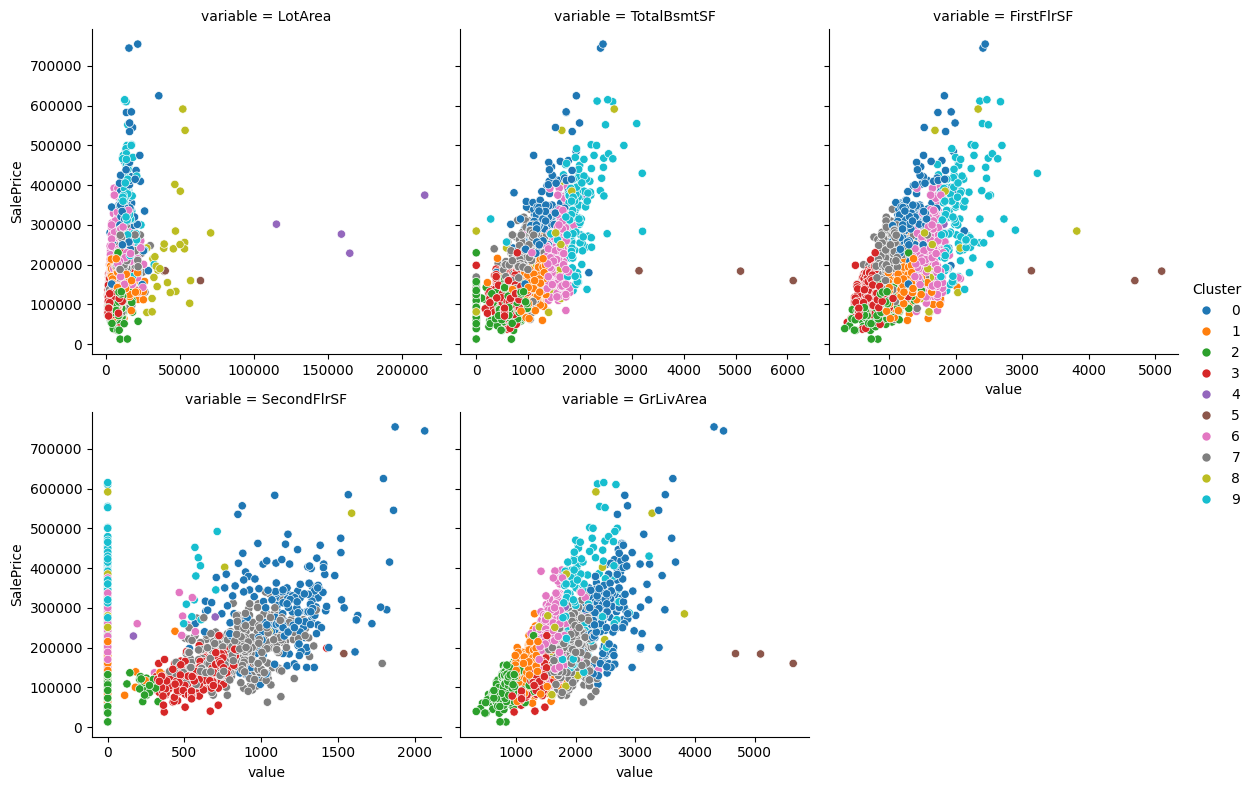

In [4]:
# Check the result of clustering
import seaborn as sns
Xy = X.copy()
Xy["Cluster"] = Xy.Cluster.astype("category")
Xy["SalePrice"] = y
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
    data=Xy.melt(
        value_vars=features, id_vars=["SalePrice", "Cluster"],
    ),
)

In [6]:
# Score dataset
from xgboost import XGBRFRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
def score_dataset(X, y, model=XGBRFRegressor()):
  for colname in X.select_dtypes(['category', 'object']):
    X[colname], _ = X[colname].factorize()
  score_val = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_log_error')
  score = -1 * score_val.mean()
  score = np.sqrt(score)
  return score

score_dataset(X, y)


XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/asaucedo/workspaces/python3/.venv/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <89AD948E-E564-3266-867D-7AF89D6488F0> /Users/asaucedo/workspaces/python3/.venv/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


In [20]:
# Cluster-distance features
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)
# Fit and transform scaled features
X_cd = kmeans.fit_transform(X_scaled)
# Label features and join to dataset
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X = X.join(X_cd)

score_dataset(X, y)


0.15841320635224973